In [69]:
import numpy as np
np.set_printoptions(suppress = True)
import qiskit as qk
from qiskit import Aer, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
import time
from qiskit import QuantumCircuit

In [70]:
def ZeroAncCRn(circuit, control, target, theta):
    circuit.p(theta/2, control)
    circuit.p(theta/2, target)
    circuit.cnot(control, target)
    circuit.p(-theta/2, target)
    circuit.cnot(control, target)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit


In [116]:

def AFTerror(qc2, n, qft_probs, delta, backend="statevector", display_bool=False):
    # returns a correlation coefficient between the qft and aft signals
    aft_probs = simulate(qc2, n, display_bool=display_bool, delta=delta, backend=backend)
    mae = np.abs(np.subtract(qft_probs, aft_probs)).mean()
    return mae

def compareAFT(n, qft_counts, display_bool=False, backend="statevector"):
    errors = []
    for d in range(1, n+1):
        print("progress: {:.2f}%".format(d/n*100))
        qcAFT = QuantumCircuit(n, n)
        qcAFT.h(n//2)
        QFT(qcAFT, n, delta=d)
        errors.append(AFTerror(qcAFT, n, qft_counts, d, backend=backend, display_bool=display_bool))
    return errors

def QFT(circuit, n, delta=10000):
    swap_registers(circuit, n)
    for i in range(n):
        circuit.h(i)
        for j in range(1, n-i):
            if j < delta:
                ZeroAncCRn(circuit, i+j, i, np.pi/2**(j))
            else:
                break

In [140]:
def simulate(qc, n, reps=2**14, display_bool=False, delta=10000, backend="statevector",
    noise = 0.01):
    # Create an empty noise model
    noise_model = NoiseModel()

    # Add depolarizing error to all single qubit u1, u2, u3 gates
    error = depolarizing_error(noise, 1)
    noise_model.add_all_qubit_quantum_error(error, ['h', 't', 'cnot', 'tdg', 'p'])

    # Print noise model info
    # print(noise_model)

    if backend == "simulator":
        qc.measure(range(n), range(n))
        # simulator = Aer.get_backend('qasm_simulator')
        simulator = AerSimulator(noise_model=noise_model)
        job_sim = simulator.run(qk.transpile(qc, simulator), shots=reps)
        result_sim = job_sim.result()
        counts = (result_sim.get_counts(qc))
        if display_bool:
            # choose appropriate filename
            filename = "charts/n={},delta={},noise={}.png".format(n, delta if delta < 9000 else "infinite", noise)
            plot_histogram(counts, legend=[], bar_labels=False, title="n={}, delta={}".format(n, delta if delta < 9000 else "infinite"), filename=filename)
            hist = plot_histogram(counts, legend=[], bar_labels=False, title="n={}, delta={}".format(n, delta if delta < 9000 else "infinite"))
            display(hist)
        return counts


    elif backend == "statevector":
        # qc.measure(range(n), range(n))
        backend = Aer.get_backend('statevector_simulator') # the device to run on
        result = backend.run(qk.transpile(qc, backend)).result()
        psi  = result.get_statevector(qc)

        probs = psi.probabilities()
        if display_bool:
            filename = "charts/probabilities,n={},delta={}.png".format(n, delta if delta < 9000 else "infinite")
            plt.bar([x for x in range(2**n)], probs, color="#781425")
            plt.title("n={}, delta={}".format(n, delta if delta < 9000 else "infinite"))
            plt.show()
            plt.savefig(filename)
        return probs[:2**n]

In [141]:
b = 3
qasm_qc = QuantumCircuit(b, b)
QFT(qasm_qc, b, delta=8)
qasm_output = qasm_qc.qasm()

In [142]:
with open("qasm_files/qasm{}qubit".format(b), 'w') as txt_file:
    txt_file.write(qasm_output)

shape of heatmap: 6 x 1
n=6, i=0


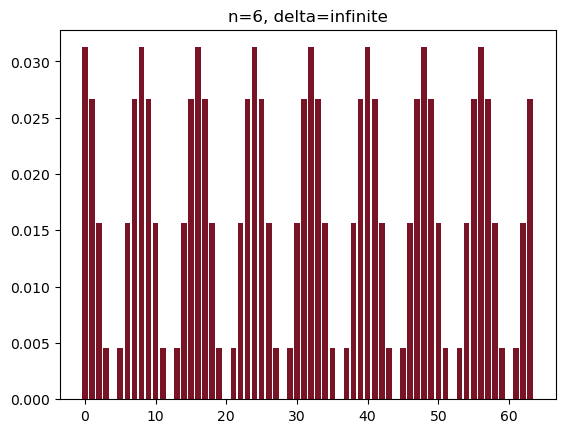

progress: 16.67%


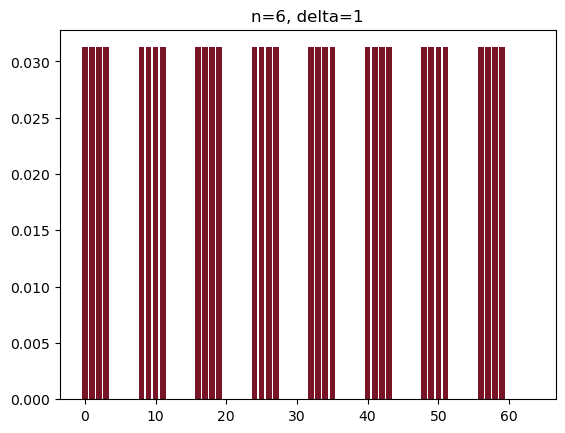

progress: 33.33%


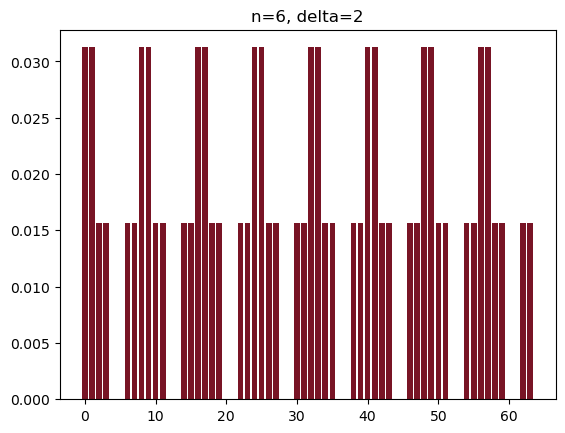

progress: 50.00%


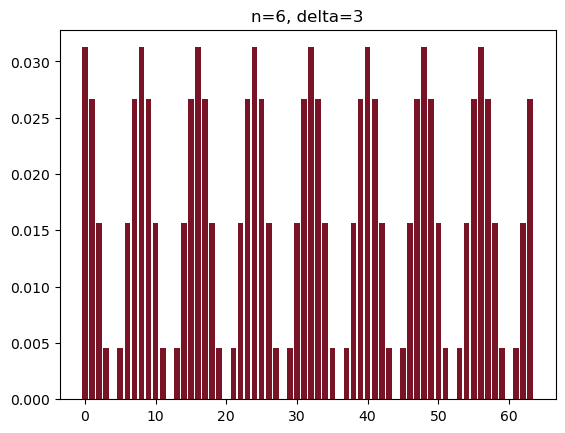

progress: 66.67%


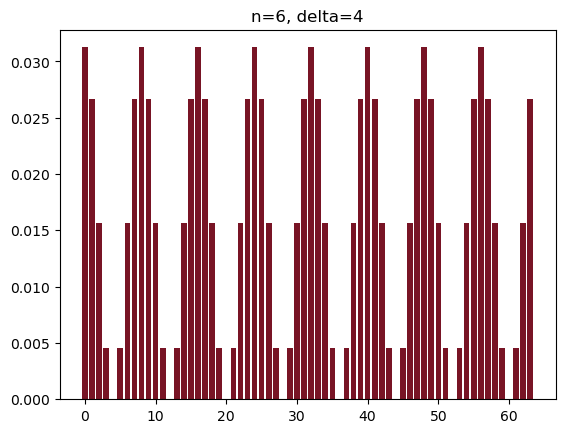

progress: 83.33%


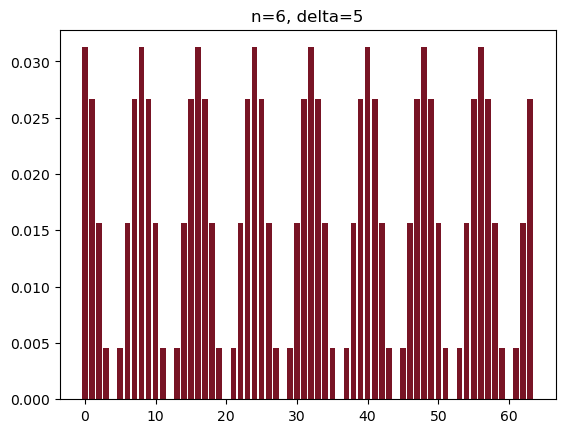

progress: 100.00%


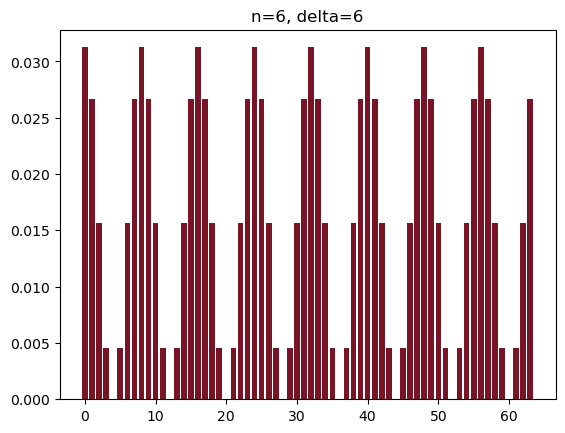

--- 2.6467623710632324 seconds ---
[[0.012]
 [0.004]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]]


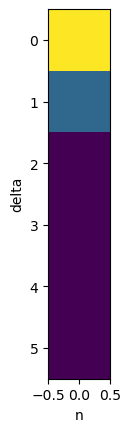

In [146]:
def compareFTs(n_low, n_high, backend="statevector", display_bool=False):
    # heatmap showing comparative error
    heatmap = np.zeros((n_high, (n_high-n_low)//2+1))

    print("shape of heatmap: {} x {}".format(heatmap.shape[0], heatmap.shape[1]))
    i = 0
    for n in range(n_low, n_high+1, 2):
        print("n={}, i={}".format(n, i))
        qcQFT = QuantumCircuit(n, n)
        qcQFT.h(n//2)
        QFT(qcQFT, n)
        qft_probs = simulate(qcQFT, n, display_bool=display_bool, backend=backend)
        start_time = time.time()
        errors = compareAFT(n, qft_probs, backend=backend, display_bool=display_bool)
        print("--- %s seconds ---" % (time.time() - start_time))
        for d in range(0, n):
            heatmap[d][i] = errors[d]
        i -=- 1

    print(np.around(heatmap, 3))
    plt.xlabel("n")
    plt.ylabel("delta")
    plt.imshow(heatmap)
    plt.savefig("charts/heatmap-{}-{}".format(n_low, n_high))

compareFTs(6,6, backend="statevector", display_bool=True)

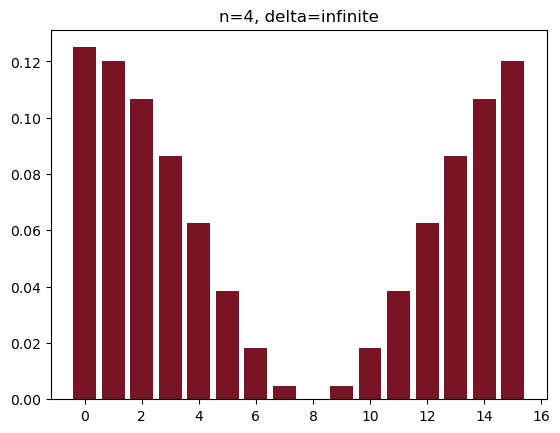

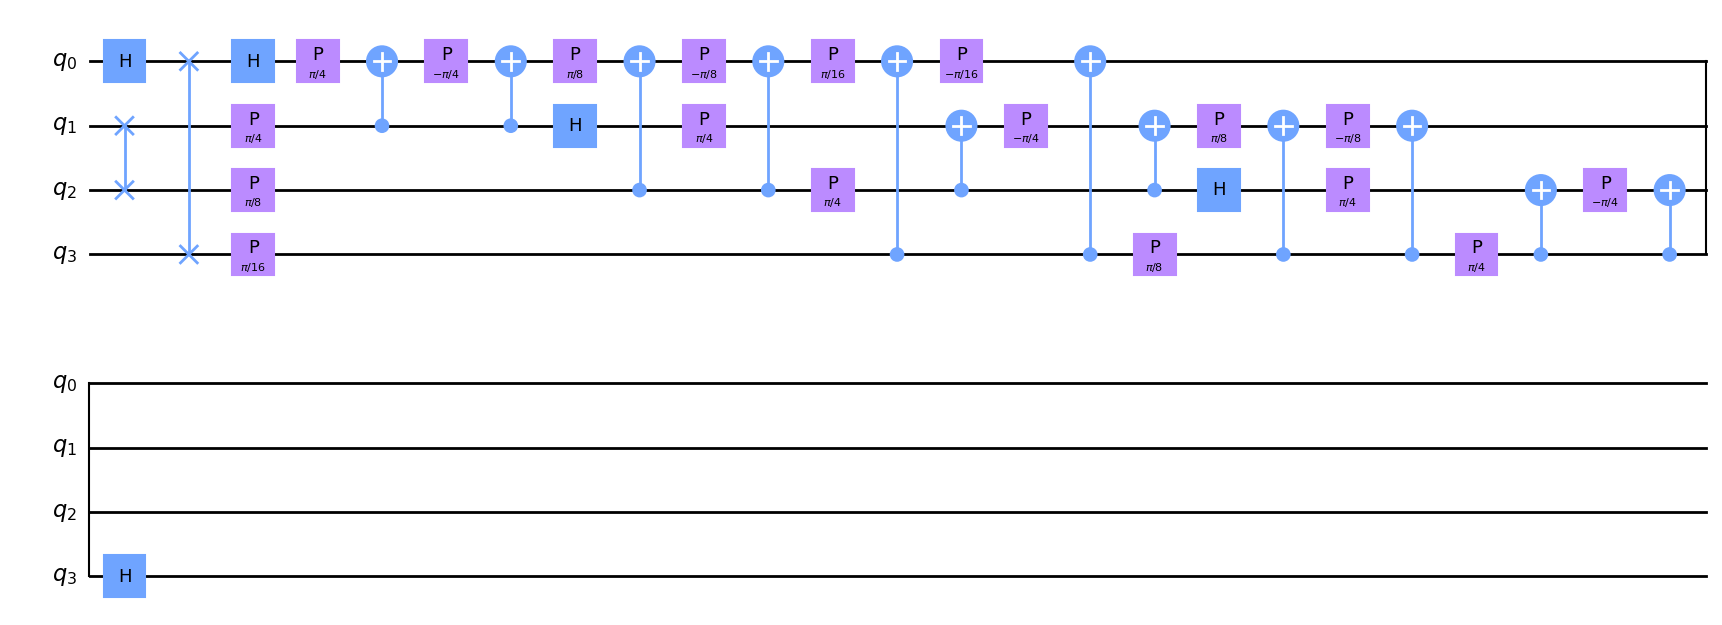

<Figure size 640x480 with 0 Axes>

In [147]:
n = 4
ac = QuantumCircuit(n)
ac.h(0)
QFT(ac, n)

probs = simulate(ac, n, display_bool=True)

ac.draw(output="mpl")